# Bike sharing demand forecast using ARIMA model

## Import Packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import sklearn.metrics

## Defining KPSS hypothesis method

In [17]:
def kpss_test(timeseries):
    """
    This function applies the KPSS hypothesis testing to verify if a time series is stationary.
    Null Hypothesis: The timeseries is stationary
    """
    # referred: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Get the data

In [3]:
# get the data
path = r"C:\Users\Sharon Alexander\OneDrive\Desktop\Data Science Career\Tableau Learning\bike_sharing_dataset\day.csv"
days_df = pd.read_csv(path)

# doing this improves readability of plots
days_df['dteday'] = pd.to_datetime(days_df['dteday'])

## Split the training and testing data

In [5]:
# split the data into 95:0.05 (complete 2 years)
X_train, X_test = train_test_split(days_df, test_size=0.05, train_size=0.95, shuffle=False, stratify=None)

The test set is small because the predictions get weaker as we go deeper into future.

## Check for outliers using boxplot

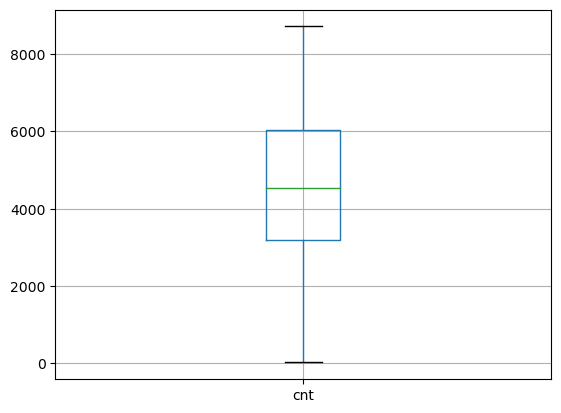

In [9]:
# Let us see if we have any outliers
X_train.boxplot(column=["cnt"])
plt.show()

There is no outlier in the data to be removed.

## Check for missing values

In [10]:
(X_train.isna().mean(axis=0) * 100).round(2)

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

This shows that there are 0%  missing value in all the columns.

## Visualizing the data

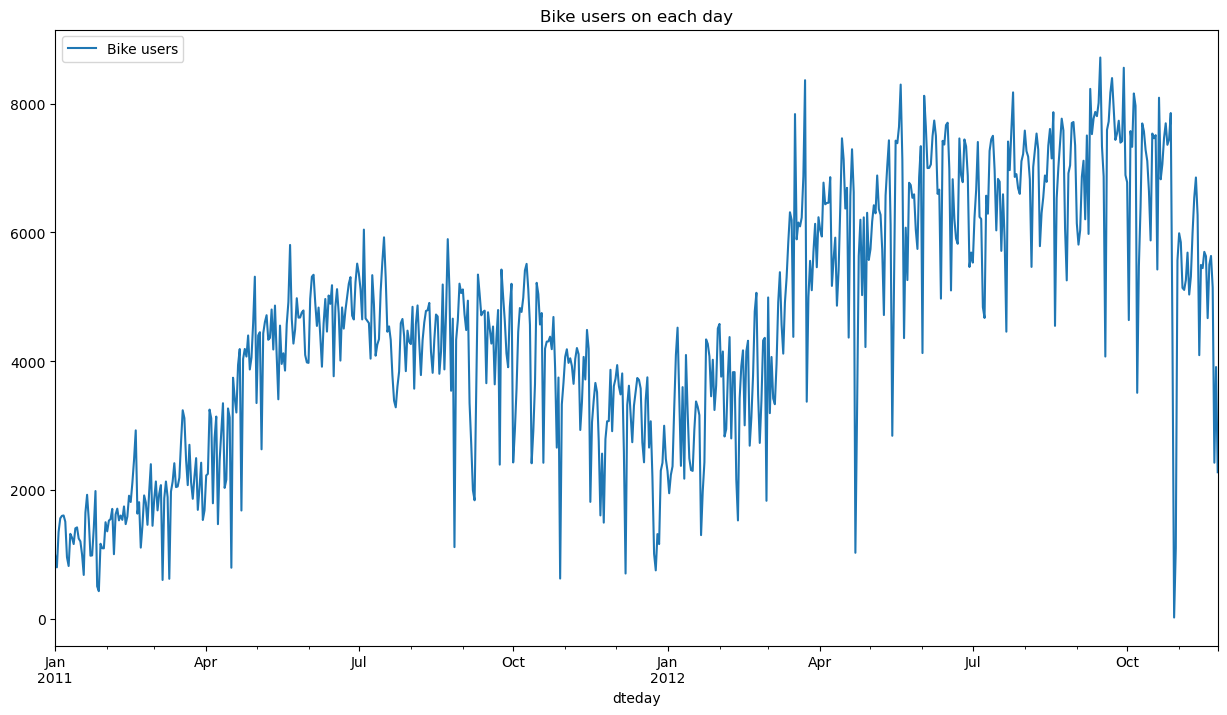

In [7]:
# plot the train data
X_train.plot(figsize=(15, 8), x='dteday', y='cnt', title="Bike users on each day", label="Bike users")
plt.show()

Observations:
1. This series has trend.
2. It has seasonality. (You can see a peak at both year's July's)
3. There are no outliers as per boxplot, but the series is noisy.
4. The variance is increasing.

## De-noising the time series data

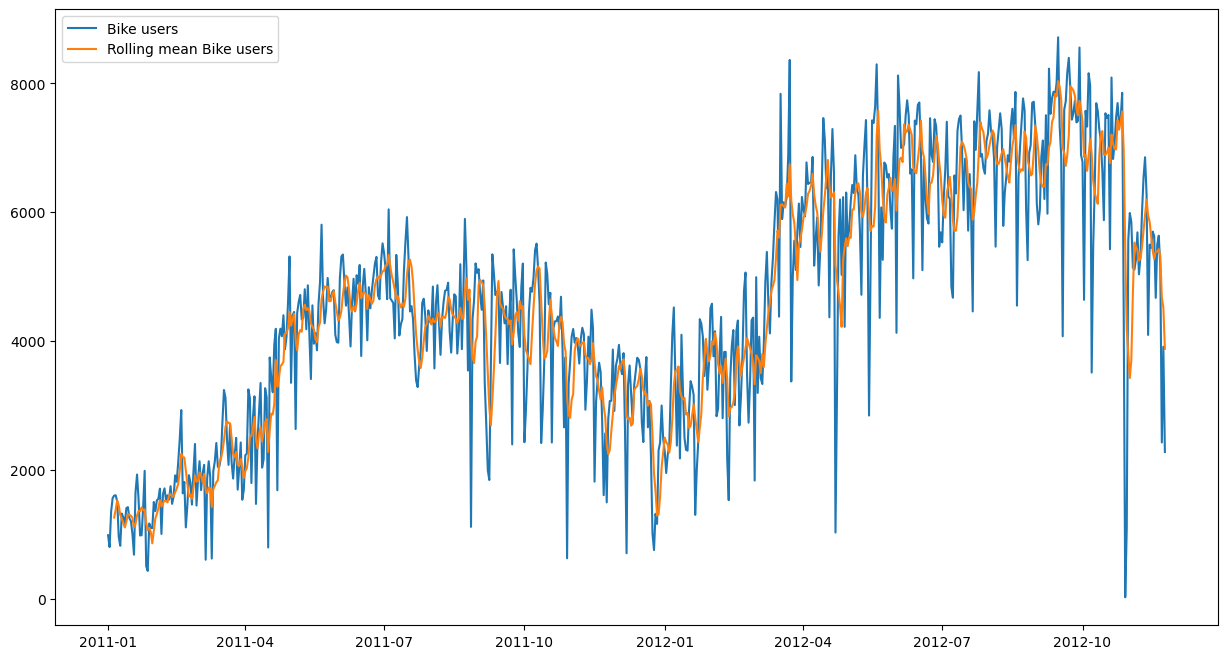

In [77]:
# Rolling mean method to de-noise the data
X_dnoised = X_train['cnt'].rolling(5).mean()
X_dnoised = X_dnoised
# plot the train data
plt.figure(figsize=(15, 8))
plt.plot(X_train['dteday'], X_train['cnt'], label='Bike users')
plt.plot(X_train['dteday'], X_dnoised, label='Rolling mean Bike users')
plt.legend()
plt.show()

In [81]:
# Now we will use the rolling mean data further for modelling
X_ts = X_dnoised[4:]

We initialised the timeseries x from 4 because we have taken the rolling window as 5.

## Handling the heteroscedasticity

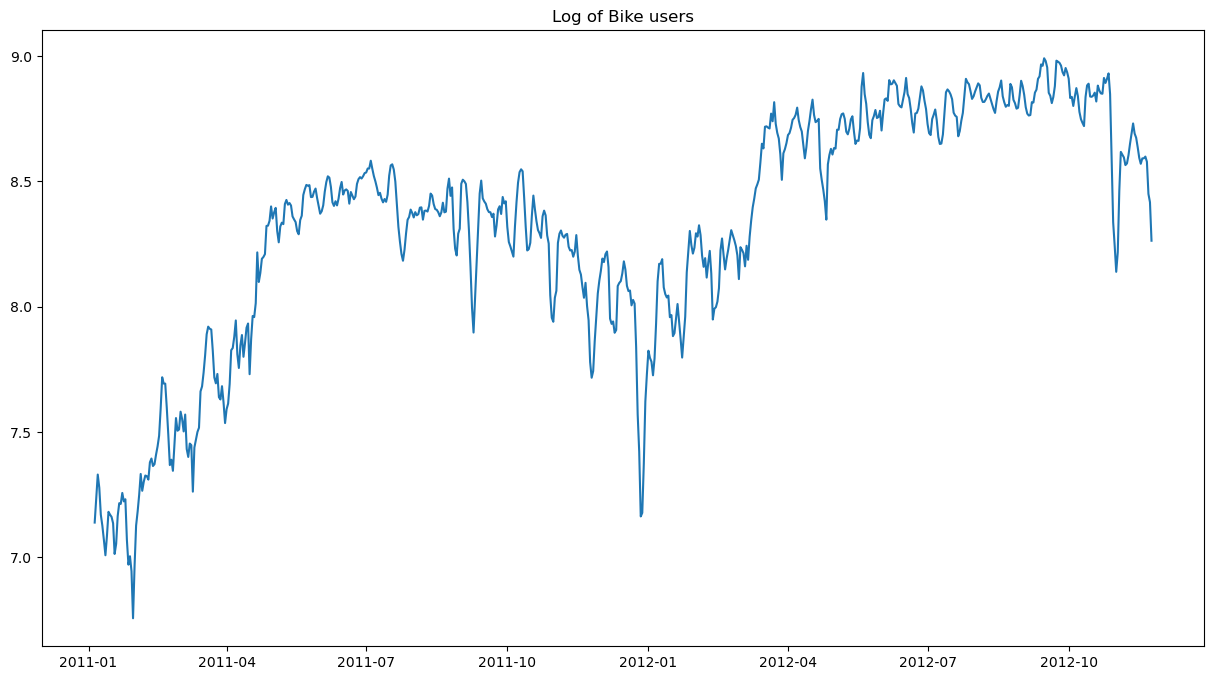

In [85]:
X_log = np.log(X_ts)
# plot the train data
plt.figure(figsize=(15, 8))
plt.plot(X_train['dteday'][4:], X_log, label='Bike users')
plt.title("Log of Bike users")
plt.show()

In [86]:
X_ts = X_log

## Finding the order of differencing to remove the seasonal trend

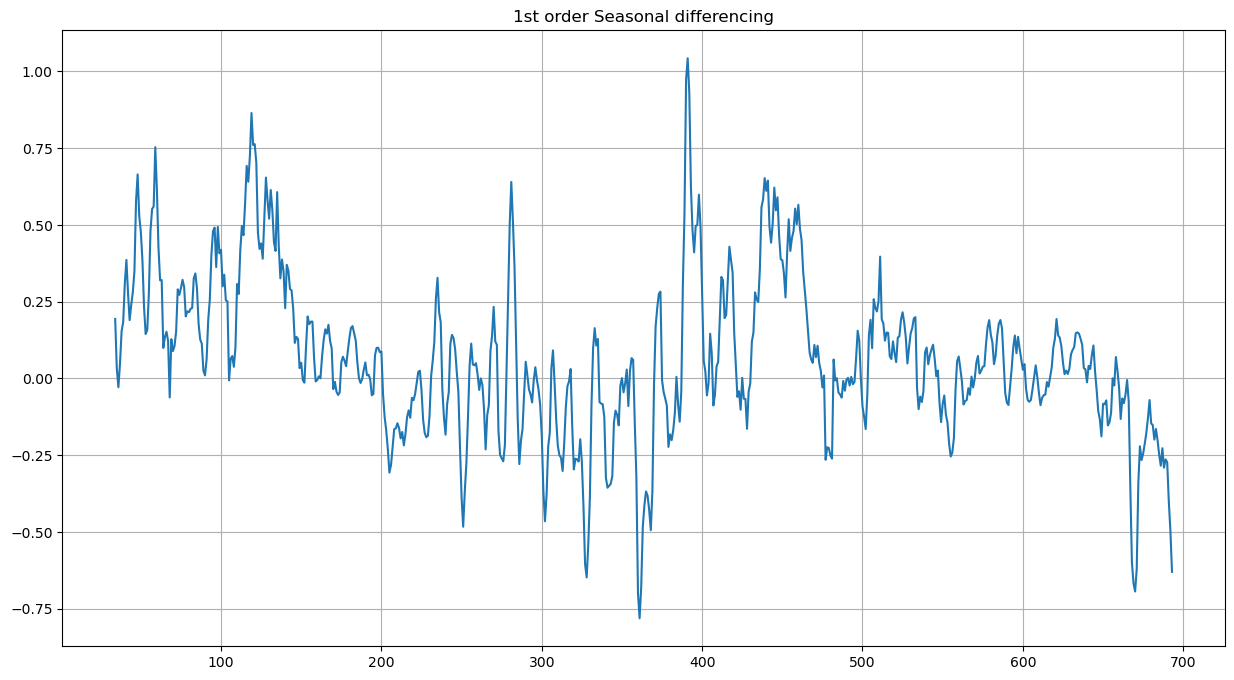

In [87]:
# number of days in a month
m = 30
X = X_ts - X_ts.shift(m)
X = X[30:]
X.plot(figsize=(15, 8), y='cnt', title="1st order Seasonal differencing")
plt.grid()
plt.show()

## Removing non-seasonal trend with 1st order differencing 

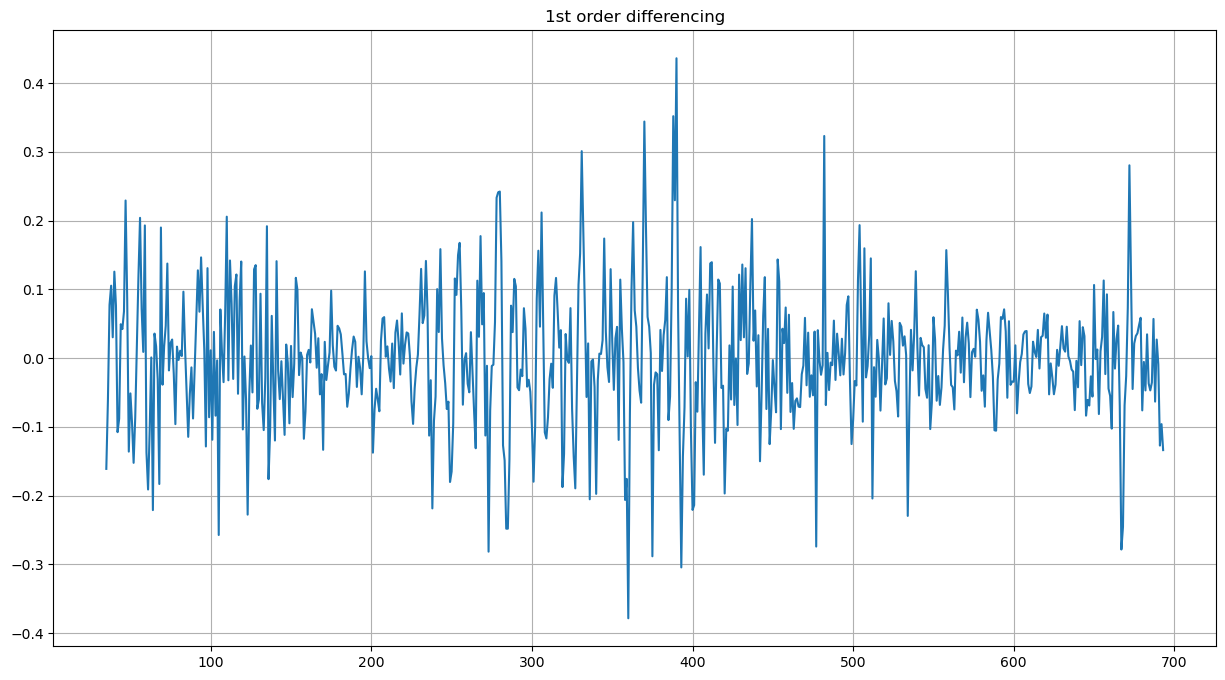

In [88]:
X = X - X.shift(1)
X = X[1:]
X.plot(figsize=(15, 8), y='cnt', title="1st order differencing")
plt.grid()
plt.show()

Now the series is nicely centered around zero.

## Check for stationarity

In [89]:
kpss_test(X)

Results of KPSS Test:
Test Statistic           0.029271
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\Sharon Alexander\AppData\Local\Temp\ipykernel_4764\2077711532.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = sm.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")


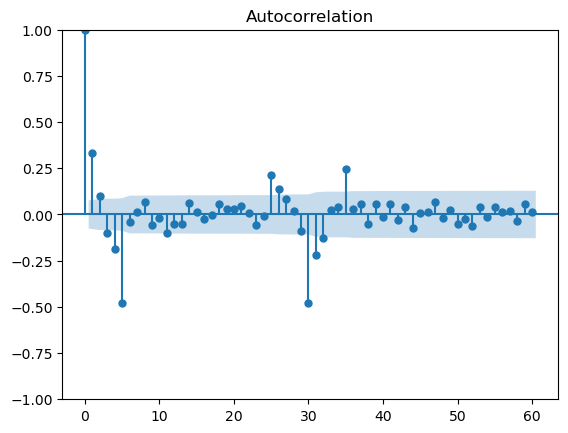

In [90]:
plot_acf(X, lags=60)
plt.show()

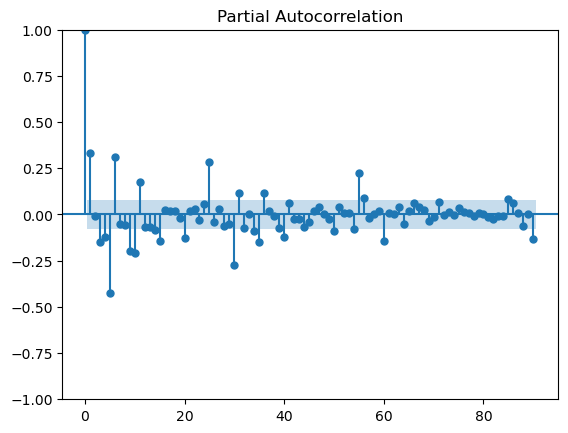

In [91]:
plot_pacf(X, lags=90)
plt.show()

Observations:
1. KPSS hypothesis test returned a p-value greater than 0.05 i.e the differenced data is stationary.
2. The ACF plot is decaying quickly, this shows that data is stationary.
3. ACF plot chopping off at 3rd lag indicates the Moving average order is 3 for non-seasonal trend.
4. The PACF plot is indicating the significant lags are present at 30, 60 and 90th lag. (Indicating a 3rd order seasonal auto regression)
5. The 13th lag in PACF is the significant lag before 30th. That indicates the non-seasonal AR order to be 13.
6. The ACF plot also chops of at the first seasonal lag, it means the seasonal MA order is 0 or 1.

In [97]:
import itertools
# set the typical ranges for p, d, q
p = range(12, 14)
d = range(1, 2)
q = range(2, 4)
sp = range(2,4)
sq = range(0, 2)
# calculate s parameter for seasonal arima i.e. the number of seasons in a given time series
s = X_ts.shape[0]//m
#take all possible combination for p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(sp, d, sq))]

We have generated the combinations for ARIMA's p,d,q and we will test it on the data. As it is a computationally heavy task, I have executed the below snippet of code on Google Colab to find out the best ARIMA model from this list.

In [98]:
print("Set of non seasonal order: ", pdq)
print("Set of seasonal order: ", seasonal_pdq)

Set of non seasonal order:  [(12, 1, 2), (12, 1, 3), (13, 1, 2), (13, 1, 3)]
Set of seasonal order:  [(2, 1, 0, 23), (2, 1, 1, 23), (3, 1, 0, 23), (3, 1, 1, 23)]


In [99]:
arima_orders = list(itertools.product(pdq, seasonal_pdq))

We have 16 combinations to check.

In [100]:
arima_orders

[((12, 1, 2), (2, 1, 0, 23)),
 ((12, 1, 2), (2, 1, 1, 23)),
 ((12, 1, 2), (3, 1, 0, 23)),
 ((12, 1, 2), (3, 1, 1, 23)),
 ((12, 1, 3), (2, 1, 0, 23)),
 ((12, 1, 3), (2, 1, 1, 23)),
 ((12, 1, 3), (3, 1, 0, 23)),
 ((12, 1, 3), (3, 1, 1, 23)),
 ((13, 1, 2), (2, 1, 0, 23)),
 ((13, 1, 2), (2, 1, 1, 23)),
 ((13, 1, 2), (3, 1, 0, 23)),
 ((13, 1, 2), (3, 1, 1, 23)),
 ((13, 1, 3), (2, 1, 0, 23)),
 ((13, 1, 3), (2, 1, 1, 23)),
 ((13, 1, 3), (3, 1, 0, 23)),
 ((13, 1, 3), (3, 1, 1, 23))]

## Looping through each order and choosing the best using AIC score

In [107]:
def create_arima(order, seasonal_order):
    model = SARIMAX(X_ts, order=order, seasonal_order=seasonal_order, trend='ct')
    model_fit = model.fit()
    return [model, model_fit]

This above snippet was run in Google Colab to save my laptop from expensive computational load.

**We got the best model as arima (12, 1, 2)x(3, 1, 0, 23) and it had the least AIC score of -1819.649**

## Build the model

In [108]:
# let's build this model
model, model_fit = create_arima(order=(12, 1, 2), seasonal_order=(3, 1, 0, 23))

C:\Users\Sharon Alexander\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sharon Alexander\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sharon Alexander\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Model evaluation on training data

In [113]:
def overall_evaluation(models):
    """
    This function iterates over the arima models and will print out the metrics for each of them.
    Metrics: RMSE, MSE, MAE, MAPE, AIC, BIC
    """
    model_names = [model[1] for model in models] # index
    RMSE_lst = [np.sqrt(model[0].mse) for model in models]
    MSE_lst = [model[0].mse for model in models]
    MAE_lst = [model[0].mae for model in models]
    MAPE_lst = [np.mean(np.abs((model[0].forecasts_error[0]/X_ts)*100)) for model in models]    
    AIC_lst = [model[0].aic for model in models]
    BIC_lst = [model[0].bic for model in models]
    metrics = {"RMSE": RMSE_lst, "MSE": MSE_lst, "MAE": MAE_lst, "MAPE": MAPE_lst, "AIC": AIC_lst, "BIC": BIC_lst}
    
    result = pd.DataFrame(metrics, index=model_names)
    return result

In [114]:
overall_evaluation([[model_fit, "arima (12, 1, 2)x(3, 1, 0, 23)"]])

,RMSE,MSE,MAE,MAPE,AIC,BIC
"arima (12, 1, 2)x(3, 1, 0, 23)",0.309067,0.095522,0.059409,0.757814,-1819.649022,-1729.623229


## Testing the model

In [121]:
def test(model):   
    start = X_ts.shape[0]
    end = X_test.shape[0] + start - 1
    y_hat = model.predict(start=start, end=end)
    # exponential transform (to get the actual value from the model as we had used log transform before)
    y_hat_exp = np.exp(y_hat)
    return y_hat_exp

def model_test_evaluation(y_pred, y):
    """
    This function returns the following metrics for a given y_pred and y.
    Metrics: RMSE, MSE, MAE, MAPE
    """    
    RMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_pred, y))
    MSE = sklearn.metrics.mean_squared_error(y_pred, y)
    MAE = sklearn.metrics.mean_absolute_error(y_pred, y)
    MAPE = np.mean(np.abs(((y_pred-y)/y)*100))
    
    metrics = {"RMSE": RMSE, "MSE": MSE, "MAE": MAE, "MAPE": MAPE}
        
    return metrics

In [122]:
# Prediciting the values for the test data
y_pred = test(model_fit)

C:\Users\Sharon Alexander\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Sharon Alexander\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


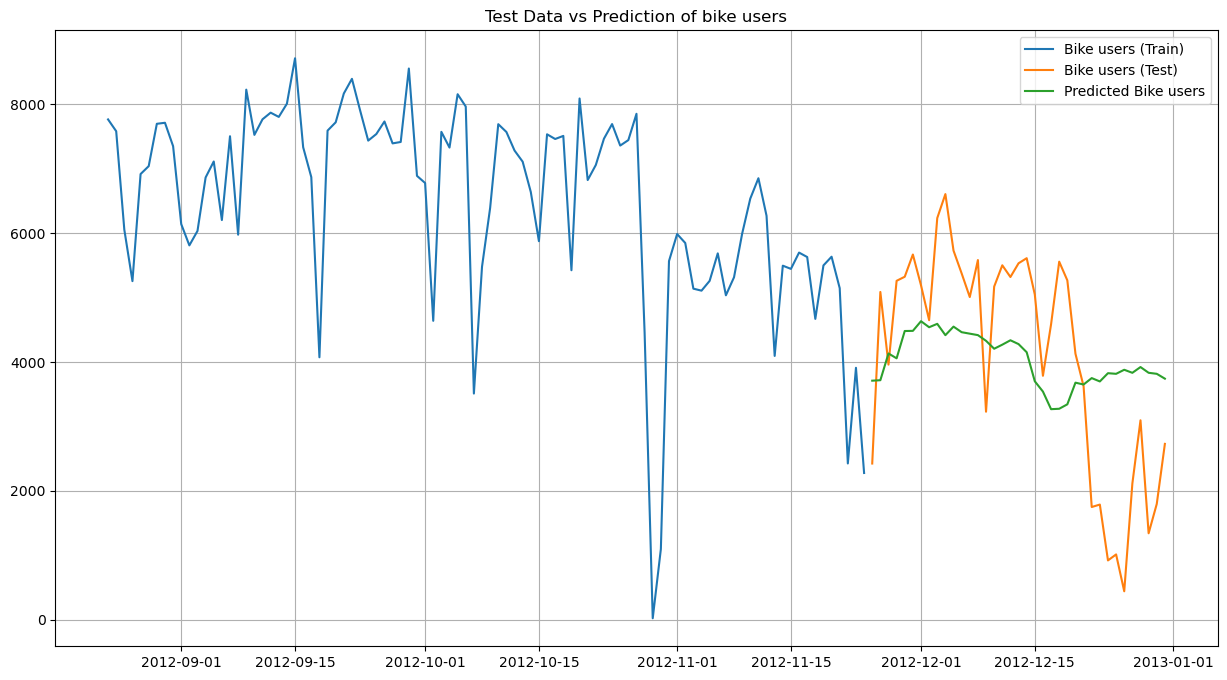

In [128]:
# plot the test and predicted data
plt.figure(figsize=(15, 8))
plt.plot(X_train['dteday'][600:], X_train['cnt'][600:], label='Bike users (Train)')
plt.plot(X_test['dteday'], X_test['cnt'], label='Bike users (Test)')
plt.plot(X_test['dteday'], y_pred, label='Predicted Bike users')
plt.legend()
plt.grid()
plt.title("Test Data vs Prediction of bike users")
plt.show()

In [123]:
model_test_evaluation(y_pred, X_test['cnt'])

{'RMSE': 1565.0273657218277,
 'MSE': 2449310.655458203,
 'MAE': 1354.0207818714628,
 'MAPE': 70.93597887941505}

## Did the model capture everything in the training data?

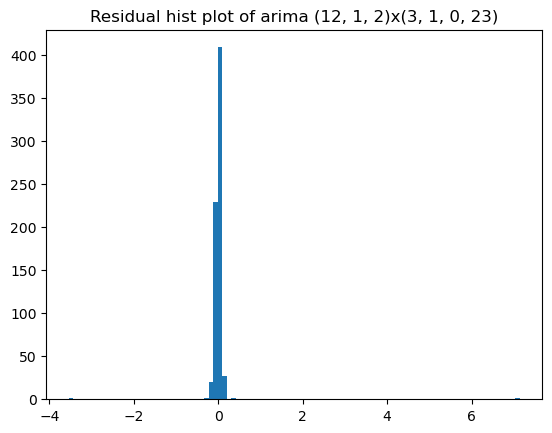

In [132]:
# Let's check the residual histogram plot
plt.hist(model_fit.resid, bins=100)
plt.title("Residual hist plot of arima (12, 1, 2)x(3, 1, 0, 23)")
plt.show()

In [133]:
model_fit.resid.describe()

count    690.000000
mean       0.005669
std        0.309239
min       -3.535701
25%       -0.031165
50%        0.006073
75%        0.035014
max        7.138373
dtype: float64

The residual plot shows that the model has captured everything from the training because the mean is 0 that distribution is normal, resembling white noise. Hence, we can be sure that this is the optimal arima model that we can get using seasonal and non-seasonal parameters

**Observations:**
Despite this ARIMA model being the best out of the combination of orders, the mean absolute percentage error is ~ 71% i.e a predicted value might vary by % up or down. Probably an ARIMA model may not yield the best result in terms of predicting the bike sharing rental demand. However, this model provides a baseline of how the demand looks upto 37 steps into the future and that itself can be game changer for decision making to owners.

**Learnings:**
This project was really enriching and I learned,
1. Timeseries and its concepts related to stationarity, trend, seasonality and cyclic behaviours.
2. KPSS hypothesis testing to check for stationarity y.
3. Methods to denoise series.
4. Methods to deal with increasing variance.
5. About ARIMA and Seasonal ARIMA models.
6. Finding an optimal ARIMA using ACF & PACF plots, AIC score.
7. Training a model and testing it.
8. Learned to plot and make visualizations in Python.